In [28]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from IPython.display import Markdown, display

pd.set_option('display.latex.repr', True)
pd.set_option('display.latex.longtable', True)

def display_md(df: pd.DataFrame, n = 15, drop=["sat_clause", "all_clause"]):
    return Markdown(df.drop(drop, axis=1).sample(n).to_markdown(index=False))

# Executive summary

The experiment descibed in this document compares 2 different algorithms for solving the 3-SAT problem. These algorithms are `prob_sat` and `gsat` and they are from the group of non-complete algorithms. It tries to answer question.

**Is ProbSAT better algorithm for solving 3-SAT hard instances than GSAT for the given parameters $p$, $c_m$, $c_b$?**



# Introduction

The experiment is trying to answer if `prob_sat` is faster than `gsat` given 3-SAT instances that are hard (have the clauses-to-variables ration near `4.3`). These instances were downloaded from the `SATLIB` benchmarks. Parameters used to answer the experiment were as follows.

* `MAX_TRIES` - $(300, 400, 500)$
* `MAX_FLIPS`  - $(20, 50, 100, 120)$
* `gsat` $p = 0.4$
* `prob_sat` $c_m = 0, c_b = 2.3$

To get rid of the bias, multiple values for `MAX_TRIES` and `MAX_FLIPS` were measured. Additionally, a new dataset was created from `SATLIB` benchmarks that has a mixture of variable and clause numbers to further decrease possible bias in the data. Dataset is available in the `dataset/` folder.


# Material

`GSAT` implementation given on the lectures was used to generate solutions to instances. `Prob_sat` implementation was written in python from scratch using the same API. Both implementations ran instances from the `dataset`, each one for 15 times with every combination of `MAX_TRIES` and `MAX_FLIPS`, so that it is possible to average anomalies. Script for running the `csv` generation is called `gen_csv.sh` and is part of the source code. Results were then saved as a csv and sample from that csv could be seen bellow. Full data is available in the `res.csv` file.

In [29]:
df = pd.read_csv("res.csv", delimiter=" ", names=["iter", "iter_max", "sat_clause", "all_clause", "filename", "alg", "max_tries", "max_flips"])
df["filename"] = df["filename"].str.removeprefix("dataset/")
df = df.drop("iter_max", axis=1)
df["solved"] = False
df["solved"] = df["all_clause"] == df["sat_clause"]
df["num_vars"] = df["filename"].str.removeprefix("uf")
df["num_vars"] = df["num_vars"].str.slice(0, 2).astype(int)

display_md(df)

|   iter | filename      | alg      |   max_tries |   max_flips | solved   |   num_vars |
|-------:|:--------------|:---------|------------:|------------:|:---------|-----------:|
|     15 | uf50-0853.cnf | gsat     |         300 |          20 | True     |         50 |
|     39 | uf50-0851.cnf | prob_sat |         500 |          20 | True     |         50 |
|    177 | uf50-0369.cnf | prob_sat |         400 |          20 | True     |         50 |
|     10 | uf20-0433.cnf | prob_sat |         300 |          20 | True     |         20 |
|     31 | uf50-0636.cnf | gsat     |         500 |          50 | True     |         50 |
|   2385 | uf75-057.cnf  | prob_sat |         400 |         120 | True     |         75 |
|    672 | uf20-0897.cnf | gsat     |         400 |         100 | True     |         20 |
|   6199 | uf75-059.cnf  | gsat     |         300 |         120 | True     |         75 |
|     56 | uf20-0433.cnf | prob_sat |         400 |          50 | True     |         20 |
|     16 | uf20-0772.cnf | prob_sat |         300 |          50 | True     |         20 |
|   1048 | uf75-066.cnf  | gsat     |         300 |         120 | True     |         75 |
|    994 | uf20-0533.cnf | gsat     |         300 |         100 | True     |         20 |
|   1350 | uf75-033.cnf  | prob_sat |         300 |          50 | True     |         75 |
|     18 | uf50-043.cnf  | gsat     |         500 |         100 | True     |         50 |
|     59 | uf20-0969.cnf | prob_sat |         400 |         100 | True     |         20 |

Some runs didn't find solution to the problem. Those runs were penalized by multiplying their number of iterations by 10. Sample of runs that did not finish after a number of tries specified can be seen below.

In [37]:
df.loc[~df["solved"], "iter"] *= 10
print("number of unsolved runs", len(df[~df["solved"]]))
display_md(df[~df["solved"]], n=5)

number of unsolved runs 306


|       iter | filename     | alg      |   max_tries |   max_flips | solved   |   num_vars |
|-----------:|:-------------|:---------|------------:|------------:|:---------|-----------:|
| 1000000000 | uf75-089.cnf | prob_sat |         500 |          20 | False    |         75 |
|  600000000 | uf75-042.cnf | prob_sat |         300 |          20 | False    |         75 |
|  800000000 | uf75-070.cnf | prob_sat |         400 |          20 | False    |         75 |
|  600000000 | uf75-042.cnf | prob_sat |         300 |          20 | False    |         75 |
|  800000000 | uf75-070.cnf | gsat     |         400 |          20 | False    |         75 |

Data acquired from the gathering step were then averaged accross `filename`, `algorithm`, `max_tries`, `max_flips` and `num_vars` columns. Resulting dataset has only 240 rows total, with `iter` equal to the average of the 15 runs that were done per configuration.

# Results

In this section preprocessed data is going to be presented in the human interpretable form, using metrics.

First metric that's going to be considered is the `mean` number of iterations. It's available in the table below. `Prob_sat` is takes lesser number of iterations than `gsat` on average. 

In [31]:
def log_mu(a: pd.Series):
    return np.log2(a).sum() / len(a)

def log_sigma2(a: pd.Series):
    mu = np.log2(a).sum() / len(a)
    return ((np.log2(a) - mu)**2).sum() / len(a) - 1


avgs = df.groupby(["filename", "alg", "max_tries", "max_flips", "num_vars"]).agg({"iter": ["mean", "median"]}).reset_index()

mean_df = pd.DataFrame({
    "algorithm": ["prob_sat", "gsat"],
    "mean": [
        np.round(avgs.loc[avgs["alg"] == "prob_sat", "iter"]["mean"].mean(), decimals=2),
        np.round(avgs.loc[avgs["alg"] == "gsat", "iter"]["mean"].mean(), decimals=2),
        ]
    })
display_md(mean_df, drop=[], n=2)


| algorithm   |    mean |
|:------------|--------:|
| prob_sat    | 11737.7 |
| gsat        | 17255.9 |

Next let's look at the cumulative distribution function (`cdf`) for both algorithms. X axis is converted to logarithmic scale to enhance clarity. No algorithm is systematically better, which is apparent from multiple intersections points of the probabilities at the start. From one point onward it seems that `prob_sat` is more succesful in finding solutions given enough number of iterations.

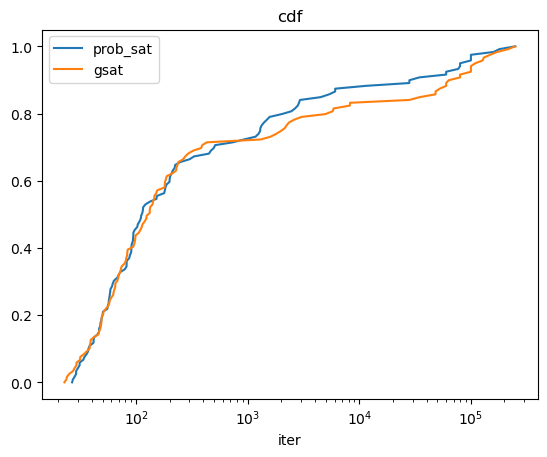

In [38]:
def cdf(df: pd.DataFrame, alg: str):
    data = np.sort(df[df.alg == alg]["iter"]["mean"])
    y = 1. * np.arange(len(data)) / (len(data) - 1)
    return data, y

def plot_cdf(xlim = None, ylim = None):
    ps_data, y = cdf(avgs, "prob_sat")
    plt.semilogx(ps_data, y, )
    plt.xlabel("iter")
    g_data, y = cdf(avgs, "gsat")
    plt.semilogx(g_data, y, )
    plt.xlabel("iter")
    plt.legend(["prob_sat", "gsat"])

    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])

plt.ticklabel_format(style="sci", scilimits=(0, 0))
plt.title("cdf")
plot_cdf()


Last metric that was not discussed in the lectures is expected log normal distribution `cdf`. The $\mu$ and $\sigma$ values of log normal distribution were used to plot empirical `cdf`. Estimated moments are shown in the table and from the `cdf` we can again see that `prob_sat` is better than `gsat`.

| algorithm   |    mu |   sigma |
|:------------|------:|--------:|
| gsat        | 8.661 |   3.828 |
| prob_sat    | 8.371 |   3.385 |

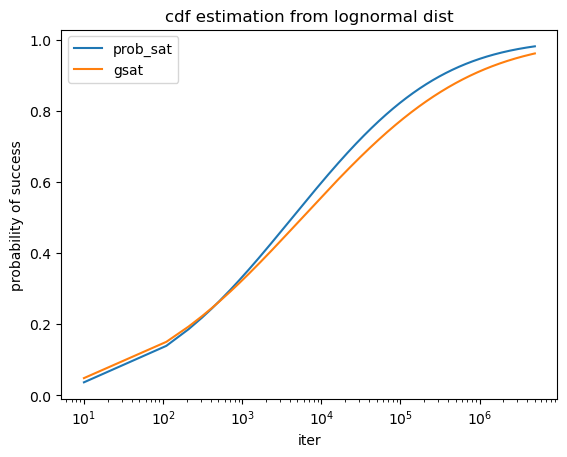

In [39]:
from scipy.stats import lognorm

def log_cdf(df: pd.DataFrame, alg: str):
    alg_data = df.loc[df["alg"] == alg, "iter"]["mean"]
    mu = log_mu(alg_data)
    sigma = np.sqrt(log_sigma2(alg_data))

    shape = sigma
    scale = np.exp(mu)

    dist = lognorm(shape, 0, scale)

    x = np.linspace(10, 5000000, 50000)
    plt.semilogx(x, dist.cdf(x))
    return mu, sigma
    

plt.title("cdf estimation from lognormal dist")
ps_mu, ps_sigma = log_cdf(avgs, alg="prob_sat")
g_mu, g_sigma = log_cdf(avgs, alg="gsat")
plt.xlabel("iter")
plt.ylabel("probability of success")
plt.legend(["prob_sat", "gsat"])

log_df = pd.DataFrame({
    "algorithm": ["prob_sat", "gsat"],
    "mu": np.round([
        ps_mu,
        g_mu,
        ], decimals=3),
    "sigma": np.round([
        ps_sigma, 
        g_sigma], decimals=3),
    })
display(display_md(log_df, n=2, drop=[]))

plt.show()




# Discussion

There is not a systematically better algorithm, which is apparent from the intersections in the `cdf`s. Given enough iterations it seems that `prob_sat` is better at finding solutions. Conclusion is that empirically `prob_sat` seems to be better than `gsat` at solving hard SAT-3 instances. So the final verdict to the question is. **Yes, ProbSAT seems to be better at solving hard 3-SAT instances given parameters $p$, $c_m$, $c_b$**.